<a href="https://colab.research.google.com/github/ThierrryScotto/fer_recognition_using_frequency_neural_network/blob/master/basic_FreNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [15]:
import numpy as np
import tensorflow as tf
import os
import glob
os.environ['LOG_LEVEL'] = 'INFO'
from src.datasets import ckextended
from src.image_processing import ImagePreProcessor
from src import utils
from src.variables import *
from scipy.fftpack import dct
from matplotlib import pyplot as plt

# Importing dataset

## Converting 1D vectors to images

In [16]:
for index, row in ckextended.iterrows():
  image = utils.convert_str_to_array(row['pixels'])
  image = utils.convert_1D_array_to_image(image, HEIGHT, WIDTH)
  utils.write_image(image, f'{OUTPUT_PATH}_{index}.png')


#Image pre-processing

In [17]:
# Caminho para a pasta de entrada
input_folder = './content/images/input_images/'

# Pasta para salvar os rostos recortados
output_folder = './content/images/preprocessed_images'

image_pre_processor = ImagePreProcessor()
# Criar a pasta de saída, se não existir
os.makedirs(output_folder, exist_ok=True)

# Processar cada imagem na pasta de entrada
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        image_path = os.path.join(input_folder, filename)
        image_pre_processor.adjust_and_crop_face(image_path, output_folder)


INFO:image_processing.py:Face 1 saved in file: ./content/images/preprocessed_images/reconstructed_image_221_face.png
INFO:image_processing.py:Face 1 saved in file: ./content/images/preprocessed_images/reconstructed_image_71_face.png
INFO:image_processing.py:Face 1 saved in file: ./content/images/preprocessed_images/reconstructed_image_335_face.png
INFO:image_processing.py:Face 1 saved in file: ./content/images/preprocessed_images/reconstructed_image_6_face.png
INFO:image_processing.py:Face 1 saved in file: ./content/images/preprocessed_images/reconstructed_image_46_face.png
INFO:image_processing.py:Face 1 saved in file: ./content/images/preprocessed_images/reconstructed_image_449_face.png
INFO:image_processing.py:Face 1 saved in file: ./content/images/preprocessed_images/reconstructed_image_419_face.png
INFO:image_processing.py:Face 1 saved in file: ./content/images/preprocessed_images/reconstructed_image_51_face.png
INFO:image_processing.py:Face 1 saved in file: ./content/images/prepr

In [18]:
# Caminhos das imagens
image_paths = glob.glob("./content/images/preprocessed_images/reconstructed_image_*")

# Lista para armazenar os arrays das imagens
image_arrays = []

# Carregar cada imagem e convertê-la em um array NumPy
for image_path in image_paths:
    if os.path.exists(image_path):
        image_array = utils.load_image(image_path)
        image_arrays.append(image_array)
    else:
        print(f"Imagem não encontrada: {image_path}")


In [19]:
γ = 0.25



In [20]:
# for i, image_array in enumerate(image_arrays):
#     print(f"Forma da imagem {i}: {image_array.shape}")

# # Exibir a quantidade de imagens carregadas
# print(f"Total de imagens carregadas: {len(image_arrays)}")

In [27]:
frequency_input = []

for image in image_arrays:
    transformed_image = dct(dct(image.T, norm='ortho').T, norm='ortho')
    frequency_input.append(utils.resize_dct(transformed_image, γ))
    # frequency_input.append(dct(dct(image_arrays[index].T, norm='ortho').T, norm='ortho'))


# Basic-FreNet

**Paremeters**

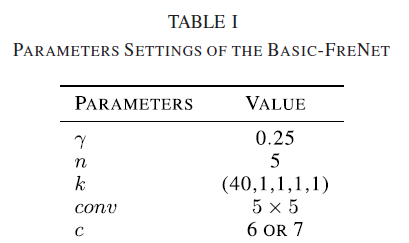

In [34]:
import tensorflow as tf

# Function to create the Learnable Multiplication Kernel (LMK) layer
class LMKLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(LMKLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = tuple(kernel_size)  # Ensure kernel_size is a tuple

    def build(self, input_shape):
        # The input_shape[-1] gives the number of input channels
        input_channels = input_shape[-1]
        self.kernel = self.add_weight(
            shape=self.kernel_size + (input_channels, self.filters),  # (height, width, input_channels, output_channels)
            initializer='truncated_normal',
            trainable=True,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=[self.filters],
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, inputs):
        conv = tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
        conv = tf.nn.bias_add(conv, self.bias)
        return conv

# Define the Basic-FreNet model using tf.keras.Model
class BasicFreNetModel(tf.keras.Model):
    def __init__(self, n_layers, k_values, conv_kernel_size, filters_summary, **kwargs):
        super(BasicFreNetModel, self).__init__(**kwargs)
        self.n_layers = n_layers
        self.lmk_layers = [LMKLayer(filters=f, kernel_size=conv_kernel_size) for f in k_values]
        self.summary_lmk_layer = LMKLayer(filters=filters_summary, kernel_size=conv_kernel_size)
        self.pool = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2, padding='SAME')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(units=2048, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(units=512, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.output_layer = tf.keras.layers.Dense(units=6, activation='softmax')

    def call(self, inputs):
        x = inputs
        for lmk_layer in self.lmk_layers:
            x = lmk_layer(x)
        x = self.summary_lmk_layer(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.output_layer(x)
        return x

# Define input shape
input_shape = (32, 32, 1)  # 32x32 grayscale images

# Create the model
n_layers = 5
k_values = [40, 1, 1, 1, 1]  # Number of filters for each LMK layer
conv_kernel_size = [5, 5]  # Kernel size for convolutional layers
filters_summary = 6  # Number of filters for summary layer

inputs = tf.keras.Input(shape=input_shape)
x = BasicFreNetModel(n_layers, k_values, conv_kernel_size, filters_summary)(inputs)

# Wrap model in tf.keras.Model
model = tf.keras.Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Print model summary
print("Model Summary")
model.summary()

# Training (example)
# dataset and labels should be preloaded and preprocessed accordingly
model.fit(np.stack(image_arrays), epochs=10, batch_size=64)

Model Summary


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_fre_net_model_13          │ (None, 6)              │     4,202,217 │
│ (BasicFreNetModel)              │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,202,217 (16.03 MB)

 Trainable params: 4,202,217 (16.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


ValueError: None values not supported.

In [ ]:

# Função para criar uma camada convolucional com inicialização de distribuição normal truncada
def conv_layer(input_tensor, num_filters, kernel_size, name):
    with tf.variable_creator_scope(name):
        in_channels = input_tensor.get_shape()[-1]
        weights = tf.get_variable('weights',
                                  shape=[kernel_size, kernel_size, in_channels, num_filters],
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        biases = tf.get_variable('biases',
                                 shape=[num_filters],
                                 initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input_tensor, weights, strides=[1, 1, 1, 1], padding='SAME')
        output = tf.nn.relu(conv + biases)
    return output

# Placeholder para a entrada
# input_shape = (None, 40, 40, 1)  # Exemplo de entrada (ajustar conforme necessário)
# inputs = tf.placeholder(tf.float32, shape=input_shape)

# Camadas convolucionais conforme especificadas
conv1 = conv_layer(frequency_input, k[0], 5, 'conv1')
conv2 = conv_layer(conv1, k[1], 5, 'conv2')
conv3 = conv_layer(conv2, k[2], 5, 'conv3')
conv4 = conv_layer(conv3, k[3], 5, 'conv4')
conv5 = conv_layer(conv4, k[4], 5, 'conv5')

# Definir a sessão do TensorFlow
sess = tf.Session()

# Inicializar variáveis
sess.run(tf.global_variables_initializer())

# Exemplo de dados de entrada
input_data = np.random.random((1, 40, 40, 1))

# Fazer uma previsão
output_data = sess.run(conv5, feed_dict={inputs: input_data})
print("Output shape:", output_data.shape)


In [ ]:
# Definindo a função de inicialização com distribuição normal truncada
def truncated_normal_init(shape, dtype=None):
    return tf.random.truncated_normal(shape, stddev=0.1, dtype=dtype)

# Parâmetros do modelo
n = 5
k = [40, 1, 1, 1, 1]
conv_kernel_size = 5
c = 6  # ou 7

# Placeholder para a entrada
# input_image = tf.keras.layers.Input(shape=(128, 128, 1))

# Construindo as camadas LMK com filtros de multiplicação
x = frequency_input
for filters in k:
    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=(conv_kernel_size, conv_kernel_size),
        padding='same',
        kernel_initializer=truncated_normal_init)(x)

# Adicionando camada de convolução e pooling
x = tf.keras.layers.Conv2D(
    filters=c,
    kernel_size=(conv_kernel_size, conv_kernel_size),
    padding='same',
    kernel_initializer=truncated_normal_init)(x)

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Adicionando camadas totalmente conectadas para classificação
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(c, activation='softmax')(x)

# Definindo o modelo
model = tf.keras.Model(inputs=frequency_input, outputs=output)

# Compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()
